<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [210]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [211]:
# fix python path if working locally
#from utils import fix_pythonpath_if_working_locally
#
#fix_pythonpath_if_working_locally()
#%matplotlib inline



In [212]:

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Check whether GPU is available

In [213]:
import torch
torch.cuda.is_available()

False

Load data from prepared local csv file

In [214]:
from darts import TimeSeries
import pandas as pd


In [215]:
series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')

Prepare train and validation splits

In [216]:
val_start = pd.Timestamp('2023-05-05')
train, val = series.split_before(val_start)


In [217]:
len(train), len(val)

(9691, 174)

In [218]:
train.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.06027413]],

       [[0.06242664]],

       [[0.0635035 ]],

       [[0.0618885 ]],

       [[0.06081225]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1986-03-13 1986-03-14 ... 1986-03-19
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [219]:
train_df = train.pd_dataframe()


In [220]:
train_df.shape[0] - train_df.dropna().shape[0]

0

In [221]:
val.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[308.69094849]],

       [[306.70355225]],

       [[305.06393433]],

       [[310.3404541 ]],

       [[308.15432739]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-05-05 2023-05-08 ... 2023-05-11
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [222]:
val_df = val.pd_dataframe()
val_df

component,Close
Date,
2023-05-05,308.690948
2023-05-08,306.703552
2023-05-09,305.063934
2023-05-10,310.340454
2023-05-11,308.154327
...,...
2023-12-28,375.279999
2023-12-29,376.040009
2024-01-01,373.455002


In [223]:
val_df.shape[0] - val_df.dropna().shape[0]

0

Plot data splits

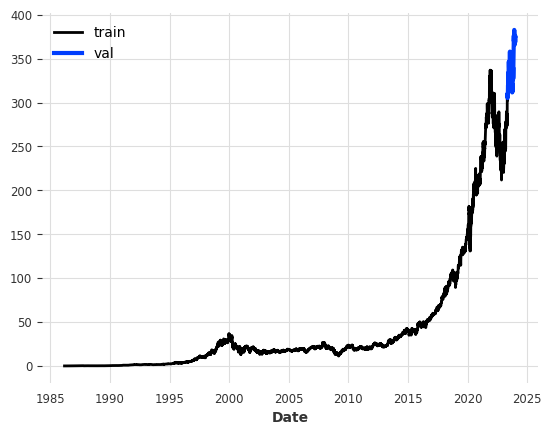

In [224]:
import matplotlib.pyplot as plt
 
train.plot(label='train')
val.plot(label='val', lw=3)
plt.legend()

Show seasonalities

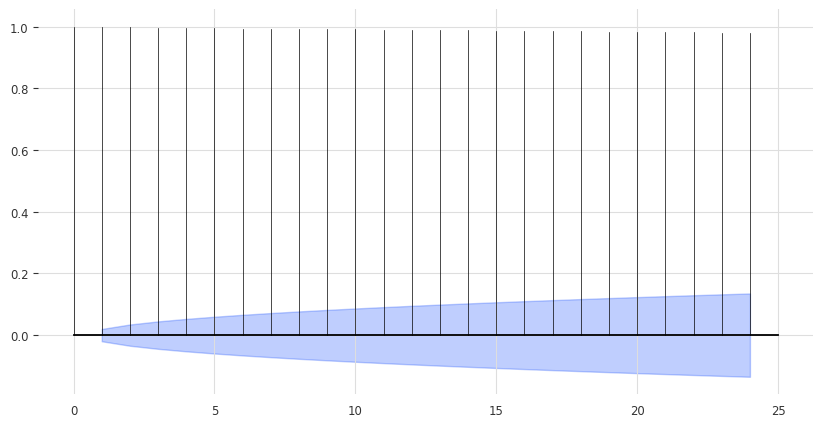

In [225]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, alpha=0.05)

Train a baseline model to benchmark against

In [226]:
from darts.models import ExponentialSmoothing


baseline_model = ExponentialSmoothing()
baseline_model.fit(train)
prediction = baseline_model.predict(len(val), num_samples=500)

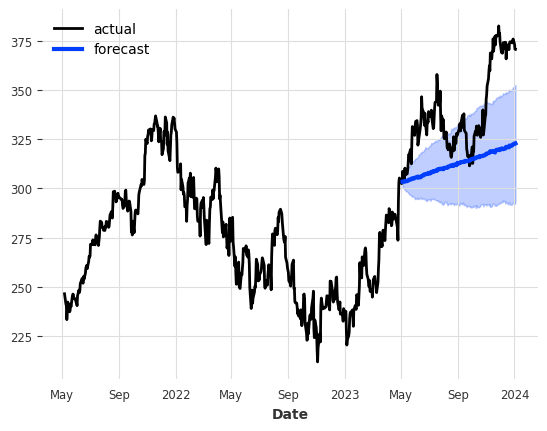

In [227]:
import matplotlib.pyplot as plt
 

actual = series.slice(val_start-pd.Timedelta(weeks=104), series.end_time())
actual.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()

In [228]:
#from darts.models import AutoARIMA
#  
#model_aarima = AutoARIMA()
#model_aarima.fit(train)
#prediction_aarima = model_aarima.predict(len(val))

In [229]:
#import matplotlib.pyplot as plt
# 
#actual.plot(label='actual')
#prediction_aarima.plot(label='forecast', lw=3)
# plt.legend()

Train our current working model

In [230]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
scaler = Scaler(verbose=True, n_jobs=-1)
filler = MissingValuesFiller(verbose=True, n_jobs=-1)
pipeline = Pipeline([filler, scaler])
#train_air_scaled = scaler.fit_transform(train)
# 
#train_air_scaled.plot()
# 
encoders = {"datetime_attribute": {"past": ["month", "year"]}, "transformer": pipeline}

In [231]:
train_history = 252 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data
n_epochs = 100 # model training epochs

In [232]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Proceeding with new model')
  model = TiDEModel(
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      # add_encoders=encoders,
      # dropout=0.1,
      n_epochs=n_epochs,
      use_reversible_instance_norm=True,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99])
#      model_name=saved_model_name,
#      force_reset=True,
#      save_checkpoints=True,    
  )  



Loading saved model


In [233]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)

In [234]:
supports_multi_ts

True

In [235]:
# train model

model.fit(train, epochs=n_epochs, num_loader_workers=10)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | rin              | RINorm           | 2     
4 | encoders         | Sequential       | 81.3 K
5 | decoders         | Sequential       | 1.2 M 
6 | temporal_decoder | _ResidualBlock   | 4.6 K 
7 | lookback_skip    | Linear           | 74.4 K
------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.562     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 294/294 [00:04<00:00, 63.52it/s, train_loss=1.170]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 294/294 [00:04<00:00, 63.51it/s, train_loss=1.170]


TiDEModel(num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, input_chunk_length=252, output_chunk_length=42, n_epochs=100, use_reversible_instance_norm=True, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None))

In [236]:
# save model
model.save(saved_model_name)


In [237]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
pred = model.predict(pred_horizon, mc_dropout=True, num_samples=500) #   len(val))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.95it/s]


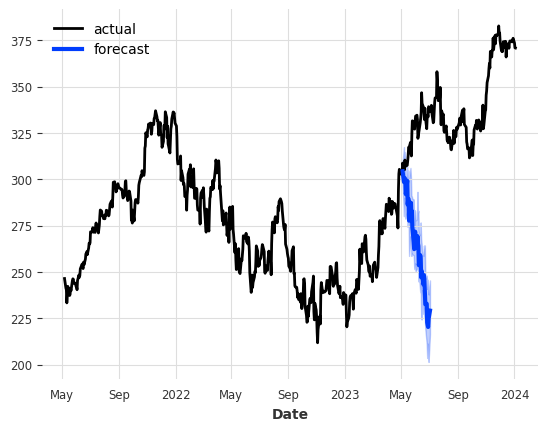

In [238]:
actual.plot(label='actual')
pred.plot(label='forecast', lw=3)
plt.legend()

Backtest Model


In [239]:

#models = [ExponentialSmoothing(),
##          NHiTSModel(input_chunk_length=6,
##            output_chunk_length=6),
#          TiDEModel(
#            input_chunk_length=24,
#            output_chunk_length=12,
#            use_reversible_instance_norm=True),
#            ]
#
#backtests = [model.historical_forecasts(series,
#                            start=.5,
#                            forecast_horizon=3)
#             for model in models]

In [240]:
# from darts.metrics import mape
#
#series.plot(label='data')
#for i, m in enumerate(models):
#    err = mape(backtests[i], series)
#    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))
#
#plt.title('Backtests with 3-months forecast horizon')
#plt.legend()

Backtest model on the full range of test data

In [241]:
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 10, 'n_jobs': -1}
                                          )
    
    return backtest


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]
Backtest RMSE = 35.89649960359903


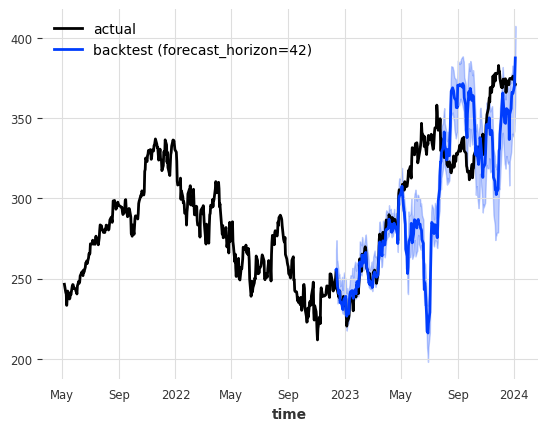

In [242]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
forecast_start = val_start-pd.Timedelta(days=200)
backtest = eval_model(model=model, series=series, start=forecast_start, forecast_horizon=pred_horizon)
actual.plot(label='actual')
backtest.plot(label=f'backtest (forecast_horizon={pred_horizon})')
print('Backtest RMSE = {}'.format(rmse(series, backtest)))